In [1]:
import pandas as pd
import numpy as np
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Package install:
I chose to use Altair instead of Matplotlib, below are the install commands for both pip and Anaconda.
<br>
- pip install altair vega_datasets
- conda install -c conda-forge altair vega_datasets

In [2]:
# Setting WeConnect color theme for plots
weconnect_colors = alt.themes.get()()
weconnect_colors.setdefault('encoding', {}).setdefault('color', {})['scale'] = {
    'range': ['#fcb239','#eaa144','#c77f5b','#b36c67','#a05974','#7b3e56','#6b3248'],
}
alt.themes.register('weconnect_colors', lambda: weconnect_colors)
alt.themes.enable('weconnect_colors')

ThemeRegistry.enable('weconnect_colors')

In [3]:
# Read in data
df = pd.read_csv('data/flight-dataset/flights-small.csv'
                 , names=['fid','month_id','day_of_month','day_of_week_id','carrier_id','flight_num','origin_city'
                          ,'origin_state', 'dest_city', 'dest_state', 'departure_delay'
                         , 'taxi_out', 'arrival_delay', 'canceled', 'actual_time', 'distance', 'capacity', 'price'])
carriers = pd.read_csv('data/flight-dataset/carriers.csv', names=['carrier_id','carrier'])
days = pd.read_csv('data/flight-dataset/weekdays.csv', names=['day_of_week_id','day_of_week'])
df = df.merge(carriers).merge(days)

### Question 1.
---
Find the maximum price of tickets between Seattle and New York, NY (i.e. Seattle to NY or NY to Seattle) for each carrier. Visualize the results in a report-ready chart which shows the top 15 most-expensive carriers for the flight (We recommend matplotlib for Python and ggplot2 for R).

In [4]:
df[((df['origin_city']=='Seattle WA')&(df['dest_city']=='New York NY'))|
   ((df['origin_city']=='New York NY')&
    (df['dest_city']=='Seattle WA'))][['carrier','price']].sort_values('price', ascending=False).head(3).style.hide_index()

carrier,price
Delta Air Lines Inc.,999
Delta Air Lines Inc.,999
Delta Air Lines Inc.,998


In [5]:
# Cleaning up some of the Carriers who's names did not import well
df.loc[df['carrier']=='ExpressJet Airlines Inc. (1)', 'carrier'] = 'ExpressJet Airlines Inc.'
df.loc[df['carrier']=='ATA Airlines d/b/a ATA', 'carrier'] = 'ATA Airlines'
df.loc[df['carrier']=='America West Airlines Inc. (Merged with US Airways 9/05. Stopped reporting 10/07.)'] = 'American West Airlines Inc.'

In [6]:
# Getting the max price flights from Seattle to New York, and setting the price to 0 if no flights are offered by that Carrier
df['max_price_sea_to_ny'] = df[((df['origin_city']=='Seattle WA')&(df['dest_city']=='New York NY'))|
   ((df['origin_city']=='New York NY')&(df['dest_city']=='Seattle WA'))].groupby('carrier')['price'].transform('max')
df['max_price_sea_to_ny'] = df['max_price_sea_to_ny'].fillna(0)
sea_to_ny_carriers = df[((df['origin_city']=='Seattle WA')&(df['dest_city']=='New York NY'))|
   ((df['origin_city']=='New York NY')&(df['dest_city']=='Seattle WA'))]['carrier'].unique()
q1 = df[(df['carrier'].isin(sea_to_ny_carriers)&df['max_price_sea_to_ny']!=0)|
   (df['carrier'].isin(sea_to_ny_carriers)==False)][['carrier','max_price_sea_to_ny']].drop_duplicates().sort_values(
    by=['max_price_sea_to_ny','carrier'], ascending=[False,True]).reset_index(drop=True)

In [7]:
# This plot will not render after downgrading to Altair 3.2 so that I can freeze the code for notebook display
# But it will run in 4.0, which is what it was written in.

# source = q1.head(15)
# bars = alt.Chart(source).mark_bar(cornerRadiusBottomRight=3,
#     cornerRadiusTopRight=3,color='#7b3e56').encode(
#     x=alt.X("max_price_sea_to_ny:Q",title='Maximum Price ($)'),
#     y=alt.Y("carrier:O",sort='-x',title='Carrier Name'))
# text = bars.mark_text(
#     align='left',
#     baseline='middle',
#     dx=3  # Nudges text to right so it doesn't appear on top of the bar
# ).encode(
#     text='max_price_sea_to_ny:Q').properties(title='Maximum Price from Seattle to New York by Carrier')
# (bars + text).properties(height=500)

<p align='left'>
    <img align="left" src="Question1Plot.png">
</p>

### Discussion:
---
- There are only 3 airlines that fly directly to New York from Seattle, I set all airlines that do not fly this route to 0.
- The max ticket price is fairly similar for all three carriers, given the limited competition on this route that is not too surprising.

### Question 2.
---
- For all the direct flights from Seattle to Boston by Alaska Airlines Inc., visualize the average cost of a ticket by day of the week.

In [8]:
q2 = df[(df['carrier']=='Alaska Airlines Inc.')&(df['origin_city']=='Seattle WA')&(df['dest_city']=='Boston MA')].sort_values('day_of_week_id')
q2['flight_count'] = q2.groupby('day_of_week')['carrier'].transform('count')

In [9]:
q2[['day_of_week','flight_count']].rename(columns={'day_of_week':'Day','flight_count':'Flights'}).drop_duplicates().style.hide_index()

Day,Flights
Monday,20
Tuesday,20
Wednesday,20
Thursday,20
Friday,25
Saturday,25
Sunday,25


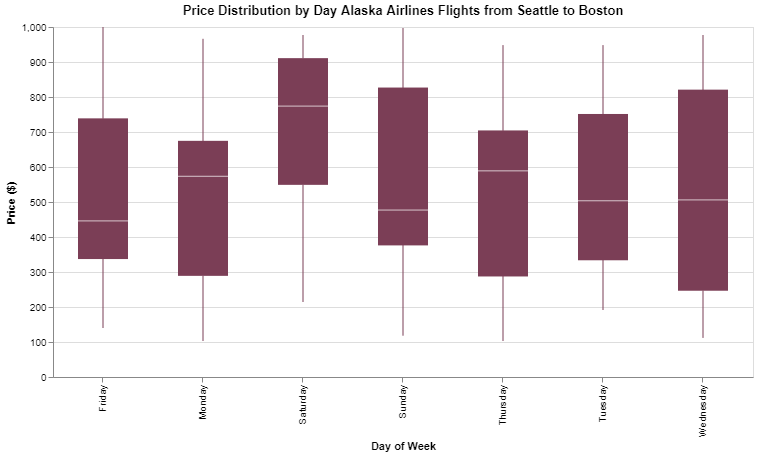

In [10]:
box = alt.Chart(q2).mark_boxplot(size=50,color='#7b3e56').encode(
     x=alt.X("day_of_week:O",title='Day of Week',sort=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday']),
    y=alt.Y("price:Q",title='Price ($)'),
).properties(title='Price Distribution by Day Alaska Airlines Flights from Seattle to Boston')
box.configure_title(fontSize=30)
(box).properties(height=350, width=700)

### Discussion:
---
- Friday and Sunday have the two cheapest median prices, this came as a bit of a surprise to me, as they are both higher volume travel days.
- Saturday is by far the most expensive day to travel, with a median price a full \$185 more than the next highest median price on Thursday.
- Wednesday has the highest variability between Q1 and Q3, and could be a good day to keep any eye on when looking for a cheap flight.
- The maximum price for each day is relatively similar with only a \$52 price difference.
- The minimum price by day, however, varies by more than twice the maximum much at \$113.


### Question 3:
---
Which flights would you recommend I consider if I wanted to travel as far as possible in the least amount of time from Seattle? Include any relevant tables/charts in your answer.

### Initial Thoughts:
- Summing all of the time fields gives a more realistic travel time estimate than just time in the air, reported as actual_time. For this reason, I chose to use a total time, rather than just the in air time.
- Per <a href="https://www.washingtonpost.com/weather/2019/02/19/flight-reaches-mph-furious-jet-stream-packs-record-breaking-speeds/"> the Washington Post</a> the record speed for a commercial jet is 801 mph (13.4 miles per minute), but the more typical speed is <a href="https://www.flightdeckfriend.com/how-fast-do-commercial-aeroplanes-fly"> 460-575 mph</a>, (7.6-9.6 miles per minute), given this information, it safe to remove the 18 outliers that have a flight speed greater than 10 miles per minute.
- It is important to make sure that the flights included have enough data that there is reasonable confidence that the flight time is reproducible. Initially I tried limiting the data set to flights with at least 30 records, however in doing so around 20% of the data is lost. By setting the cut off to 25 flights instead of 30, it allows only a 5% data loss, while still retaining retaining a fairly similar sample size for each flight number.
- The percentage of canceled flights by flight number may be something to consider in a larger data set, but for this set any flight number with more than 25 records had no cancelations.

In [11]:
q3 = df[(df['origin_city']=='Seattle WA')]
q3 = q3[['flight_num', 'carrier', 'day_of_week','dest_city','departure_delay', 'taxi_out', 'arrival_delay',
       'actual_time', 'distance', 'price', 'canceled']]
# These columns were loaded in as objects, and need to be transformed into integers to perform calculations
num_cols = ['departure_delay', 'taxi_out', 'arrival_delay','actual_time', 'distance', 'price', 'canceled']
for i in num_cols:
    q3[i] = q3[i].astype(int) 
# The total time is a more interesting metric than just time in the air
q3['total_time'] = q3['departure_delay'] + q3['taxi_out'] + q3['arrival_delay'] + q3['actual_time']
q3['miles_per_min'] = round(q3['distance']/q3['total_time'],1)
q3['delay_time'] = q3['total_time'] - q3['actual_time']

In [12]:
print("Data loss using 25 samples: {}%".format(round((q3.shape[0] - q3[q3.groupby('flight_num')['carrier'].transform('count')>=25].shape[0])/q3.shape[0]*100),2))
print("Data loss using 30 samples: {}%".format(round((q3.shape[0] - q3[q3.groupby('flight_num')['carrier'].transform('count')>=30].shape[0])/q3.shape[0]*100),2))

Data loss using 25 samples: 5%
Data loss using 30 samples: 18%


In [13]:
# Calculated fields for plotting
q3 = q3[q3['distance']/q3['actual_time']<10]
q3 = q3[q3.groupby('flight_num')['carrier'].transform('count')>=25]
q3['mean_total_time'] = q3.groupby('flight_num')['total_time'].transform('mean').astype(int)
q3['mean_miles_per_min'] = round(q3.groupby('flight_num')['miles_per_min'].transform('mean'),1)
q3['mean_price'] = q3.groupby('flight_num')['price'].transform('mean').astype(int)
q3['total_flights'] = q3.groupby('flight_num')['carrier'].transform('count')
q3['mean_delay_time'] = q3.groupby('flight_num')['delay_time'].transform('mean').astype(int)
q3['price_per_mile'] = q3['distance']/q3['price'].astype(int)
q3['mean_miles_per_dollar'] = round(q3.groupby('flight_num')['price_per_mile'].transform('median'),1)
q3_groupby_flight_num = q3[['flight_num','carrier','dest_city','mean_miles_per_min','distance','mean_delay_time'
                            ,'mean_total_time','mean_price','mean_miles_per_dollar','total_flights']].sort_values(
    'mean_miles_per_min', ascending=False).drop_duplicates().reset_index(drop=True)
q3_groupby_flight_num.rename(columns={'flight_num':'Flight Number','carrier':'Carrier','dest_city':'Destination','distance':'Miles'
                                      ,'mean_miles_per_min':'Miles/Min','mean_total_time':'Travel Time','mean_price':'Price','mean_delay_time':'Delays'
                                      ,'mean_miles_per_dollar':'Miles/Dollar','total_flights':'Number of Flights'},inplace=True)
q3_groupby_flight_num.index = range(1,len(q3_groupby_flight_num)+1)

## The top 10 most time efficient flights

In [14]:
q3_groupby_flight_num.head(10)

,Flight Number,Carrier,Destination,Miles/Min,Miles,Delays,Travel Time,Price,Miles/Dollar,Number of Flights
1,968,Delta Air Lines Inc.,Atlanta GA,8.4,2182,-8,262,539,3.9,30
2,794,Alaska Airlines Inc.,Albuquerque NM,8.2,1180,-23,147,542,2.4,31
3,112,US Airways Inc.,Philadelphia PA,8.1,2378,13,299,547,4.9,31
4,2615,Southwest Airlines Co.,Baltimore MD,8.0,2335,11,296,455,6.9,26
5,782,US Airways Inc.,Philadelphia PA,7.9,2378,9,305,584,4.0,31
6,2339,Delta Air Lines Inc.,Atlanta GA,7.9,2182,7,277,506,4.3,26
7,4,Alaska Airlines Inc.,Washington DC,7.8,2329,12,306,577,4.2,62
8,1082,United Air Lines Inc.,Newark NJ,7.8,2402,5,309,489,4.4,27
9,734,Alaska Airlines Inc.,Boston MA,7.8,2496,18,324,598,4.0,31
10,32,Alaska Airlines Inc.,Philadelphia PA,7.8,2378,12,313,478,5.6,30


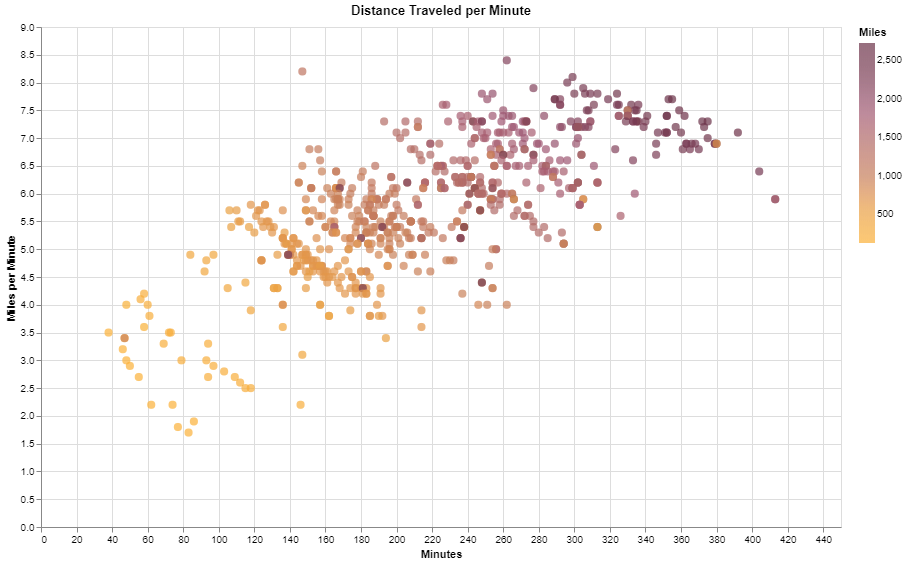

In [15]:
source = q3_groupby_flight_num
alt.Chart(source).mark_circle(size=65).encode(
    x=alt.X('Travel Time',title='Minutes'),
    y=alt.Y('Miles/Min',title='Miles per Minute'),
    color=alt.Color('Miles', title='Miles'),
    #size =alt.Size('Number of Flights',title='Number of Flights'),
    tooltip=['Flight Number', 'Carrier', 'Destination', 'Miles', 'Miles/Min', 'Price', 'Miles/Dollar','Number of Flights']
).properties(title='Distance Traveled per Minute',height=500, width=800).interactive()

### Discussion
---
- The most time efficient flight in the set, is Delta flight 968 to from Seattle to Atlanta, averaging 8.4 miles per minute. <br>
- Another flight of note for both high time efficiency, and good mile/dollar value is Southwest flight 2615 from Seattle to Baltimore. Coming in 4th overall in miles/min and 1st in miles/dollar, this is a good flight to look at for time and price efficiency.
- The two most efficient flights both consistently leave and arrive early, which might be inflating their numbers slightly. Although they get to the destination very quickly, this could still lead to a bad user experience. Missing a flight because it left 5 minutes early or being stuck at the destination airport waiting for a ride because your flight arrived 45 minutes early are not great user experiences, despite getting to the destination very quickly.
- Shorter flights tend to have worse distance per minute efficiency, which makes sense for several reasons. There is about 35 minutes of time spent on delays on average, and with a shorter flight distance, this will have a larger impact on those flights. The flight speed for ascending and descending is also slower than at cruising speed, and on shorter flights, this is a larger percentage of the time in the air.
- I considered looking into connecting flights, however, because of the added time spent not in flight, as well as the additional time added by layovers, it does not seem likely that this will be more time efficient.